In [1]:
# Makes the display take up more of the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2

In [3]:
import os
from sympy import *

In [4]:
os.getcwd()

'/home/stev/anaconda3/exp/Fusion'

In [5]:
#import sys
#sys.path.append('Week5')

In [6]:
from camera import Camera
import structure
import processor
import features

In [7]:
def dino(filepath1,filepath2):
    # Dino
    img1 = cv2.imread(filepath1)
    img2 = cv2.imread(filepath2)
    pts1, pts2 = features.find_correspondence_points(img1, img2)
    points1 = processor.cart2hom(pts1)
    points2 = processor.cart2hom(pts2)

    fig, ax = plt.subplots(1, 2,  figsize=(12,7))
    ax[0].autoscale_view('tight')
    ax[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    ax[0].plot(points1[0], points1[1], 'r.')
    ax[1].autoscale_view('tight')
    ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    ax[1].plot(points2[0], points2[1], 'r.')
    fig.show()

    height, width, ch = img1.shape
    intrinsic = np.array([  # for dino
        [2360, 0, width / 2],
        [0, 2360, height / 2],
        [0, 0, 1]])

    return points1, points2, intrinsic

In [8]:
def find_correspondence_points(img1, img2):
    sift = cv2.xfeatures2d.SIFT_create()
    #sift = cv2.SIFT()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(
        cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), None)
    kp2, des2 = sift.detectAndCompute(
        cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), None)

    # Find point matches
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply Lowe's SIFT matching ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good.append(m)

    src_pts = np.asarray([kp1[m.queryIdx].pt for m in good])
    dst_pts = np.asarray([kp2[m.trainIdx].pt for m in good])

    # Constrain matches to fit homography
    retval, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 100.0)
    mask = mask.ravel()

    # We select only inlier points
    pts1 = src_pts[mask == 1]
    pts2 = dst_pts[mask == 1]

    return pts1.T, pts2.T

/home/stev/anaconda3/envs/fusion/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


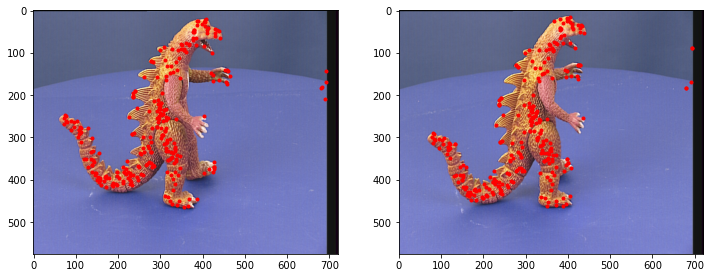

In [9]:
points1, points2, intrinsic = dino('Dino/viff.003.ppm','Dino/viff.001.ppm')

In [10]:
# Calculate essential matrix with 2d points.
# Result will be up to a scale
# First, normalize points
points1n = np.dot(np.linalg.inv(intrinsic), points1)
points2n = np.dot(np.linalg.inv(intrinsic), points2)

In [11]:
#TODO
# calculate essential matrix
E = structure.compute_essential_normalized(points1n, points2n)
print('Computed essential matrix:')

T=Matrix(-E / E[0][1]);T

Computed essential matrix:


Matrix([
[-0.155574611927225,                -1.0, 0.00409092444763189],
[  1.10452002511794, -0.0787933843515275,  -0.191465920761836],
[0.0237428514818378,   0.182178987900542, 4.46205107704189e-5]])

In [12]:
# Given we are at camera 1, calculate the parameters for camera 2
# Using the essential matrix returns 4 possible camera paramters
P1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
P2s = structure.compute_P_from_essential(E)

In [13]:
ind = -1
for i, P2 in enumerate(P2s):
    # Find the correct camera parameters
    d1 = structure.reconstruct_one_point(
                points1n[:, 0], points2n[:, 0], P1, P2)

    # Convert P2 from camera view to world view
    P2_homogenous = np.linalg.inv(np.vstack([P2, [0, 0, 0, 1]]))
    d2 = np.dot(P2_homogenous[:3, :4], d1)

    if d1[2] > 0 and d2[2] > 0:
        ind = i

In [14]:
P2 = np.linalg.inv(np.vstack([P2s[ind], [0, 0, 0, 1]]))[:3, :4]
#tripoints3d = structure.reconstruct_points(points1n, points2n, P1, P2)
tripoints3d = structure.linear_triangulation(points1n, points2n, P1, P2)

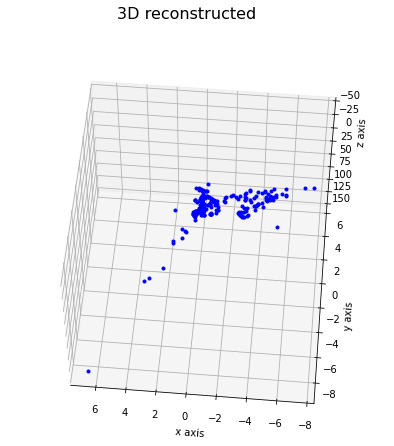

In [15]:
fig = plt.figure(figsize=(12,7))
fig.suptitle('3D reconstructed', fontsize=16)
ax = fig.gca(projection='3d')
ax.plot(tripoints3d[0], tripoints3d[1], tripoints3d[2], 'b.')
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
ax.view_init(elev=-125, azim=85)
plt.show()

/home/stev/anaconda3/envs/fusion/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


[[ 6.25182286e+08  3.66004804e+07 -1.06536613e+08]
 [ 3.66004804e+07  5.22050633e+08  5.52662367e+06]
 [-1.06536613e+08  5.52662367e+06  1.84209548e+07]]


/home/stev/anaconda3/envs/fusion/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()
/home/stev/anaconda3/envs/fusion/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


[[ 16916.57043883  51871.63851705  11592.10995087]
 [ 51871.63851705 164477.31894579  10531.95175412]
 [ 11592.10995087  10531.95175412 123331.65272915]]
[[19244338.09322248 -8539260.90190183  3423885.35108844]
 [-8539260.90190183 48691325.78414404   820342.71854864]
 [ 3423885.35108844   820342.71854864   731070.9099242 ]]


/home/stev/anaconda3/envs/fusion/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()
/home/stev/anaconda3/envs/fusion/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


[[7974150.59326885  711145.9866514   -24908.52270611]
 [ 711145.9866514  5163277.90317617  329157.79483359]
 [ -24908.52270611  329157.79483359   21610.20510343]]
[[ 5294876.06191116 12419007.51033034  1156408.3828749 ]
 [12419007.51033034 29216818.9369818   3471106.72249831]
 [ 1156408.3828749   3471106.72249831  6770786.43955714]]


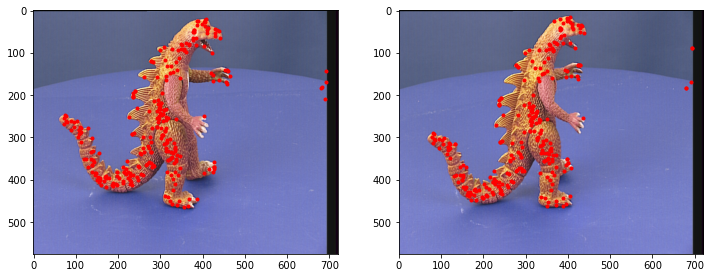

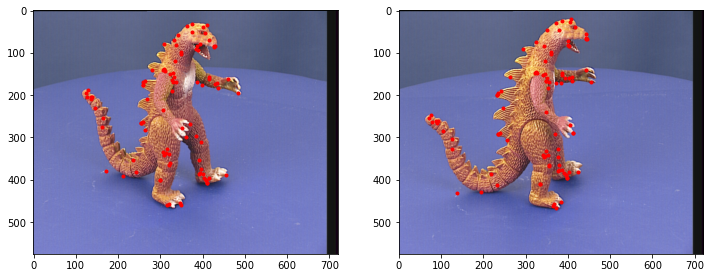

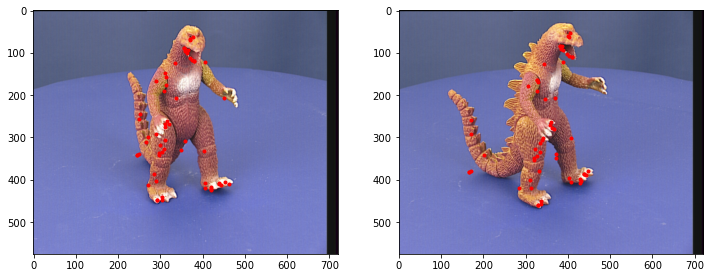

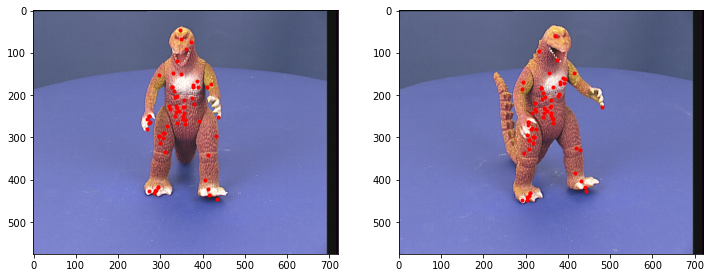

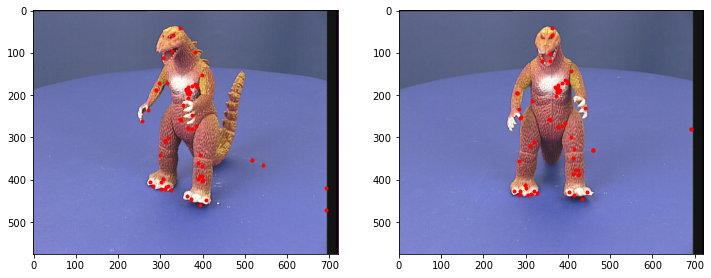

In [32]:
threeD_lst=[]
E_lst=[]
fl_lst=['Dino/viff.001.ppm', 'Dino/viff.003.ppm','Dino/viff.006.ppm', 'Dino/viff.009.ppm','Dino/viff.012.ppm', 'Dino/viff.015.ppm']

for i in range(len(fl_lst)-1):
    points1, points2, intrinsic = dino(fl_lst[i+1],fl_lst[i])
    
    points1n = np.dot(np.linalg.inv(intrinsic), points1)
    points2n = np.dot(np.linalg.inv(intrinsic), points2)
    
    E = structure.compute_essential_normalized(points1n, points2n)
    
    #print(E.T@E)
    E = -E / E[0][1]
    E_lst.append(E)
    
    P1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
    P2s = structure.compute_P_from_essential(E)
    
    ind = -1
    for i, P2 in enumerate(P2s):
        # Find the correct camera parameters
        d1 = structure.reconstruct_one_point(
                    points1n[:, 0], points2n[:, 0], P1, P2)

        # Convert P2 from camera view to world view
        P2_homogenous = np.linalg.inv(np.vstack([P2, [0, 0, 0, 1]]))
        d2 = np.dot(P2_homogenous[:3, :4], d1)

        if d1[2] > 0 and d2[2] > 0:
            ind = i
            
    P2 = np.linalg.inv(np.vstack([P2s[ind], [0, 0, 0, 1]]))[:3, :4]
    #tripoints3d = structure.reconstruct_points(points1n, points2n, P1, P2)
    tripoints3d = structure.linear_triangulation(points1n, points2n, P1, P2)
    
    threeD_lst.append(tripoints3d)

In [35]:
i=3
E_lst[i].T-E_lst[i]

array([[ 0.        ,  2.19858457,  0.12704992],
       [-2.19858457,  0.        ,  0.02923078],
       [-0.12704992, -0.02923078,  0.        ]])

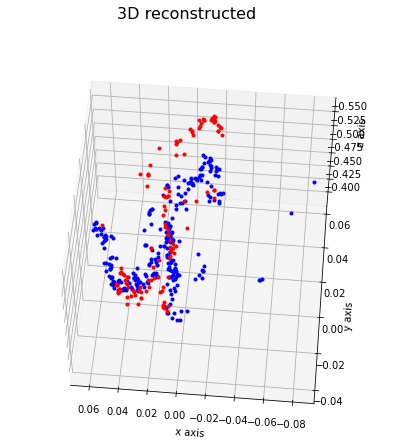

In [29]:
fig = plt.figure(figsize=(12,7))
fig.suptitle('3D reconstructed', fontsize=16)
ax = fig.gca(projection='3d')
ax.plot(threeD_lst[0][0], threeD_lst[0][1], threeD_lst[0][2], 'b.')
ax.plot(threeD_lst[1][0], threeD_lst[1][1], threeD_lst[1][2], 'r.')
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
ax.view_init(elev=-125, azim=85)
plt.show()

http://www.cse.psu.edu/~rtc12/CSE486/lecture19.pdf

In [38]:
F=np.array([[-0.00310695, -0.0025646, 2.96584],
          [-0.028094, -0.00771621, 56.3813],
          [13.1905, -29.2007, -9999.79]])

Matrix(F)

Matrix([
[-0.00310695,  -0.0025646,  2.96584],
[  -0.028094, -0.00771621,  56.3813],
[    13.1905,    -29.2007, -9999.79]])

In [40]:
x=343.53
y=221.7005

p=np.array([[x],[y],[1]])
Matrix(p)

Matrix([
[  343.53],
[221.7005],
[     1.0]])

In [50]:
Matrix(F@p)

Matrix([
[   1.3299363642],
[45.019480564895],
[-11942.26732535]])